<a href="https://colab.research.google.com/github/julia-e-ma/movies/blob/main/RandomMovieGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# imports and google drive authorization
from google.colab import auth
auth.authenticate_user()
import random
import pandas as pd
import gspread
from google.auth import default
import ipywidgets as widgets
from ipywidgets import HBox, VBox
import matplotlib.pyplot as plt
import numpy as np
creds, _ = default()
gc = gspread.authorize(creds)

This notebook is based off of the movie spreadsheet. The spreadsheet contains a list of movies we'd like to watch together. If you can't decide on a movie, you can use this notebook to select parameters (genre, runtime, preferred actors, etc.) to decide on a movie to watch.

Add google form integration so we can update movies when watched and movies when we find a new one we want to watch.

In [ ]:
# list of streaming platforms we both have
streaming_platforms = [
    'Netflix',
    'Hulu',
    'HBO Max',
    'Paramount+',
    'Disney+',
    'Roku',
    'Peacock'
]

In [ ]:
# read in the existing spreadsheet
doc = gc.open('mega movie list')
worksheet = doc.sheet1
rows = worksheet.get_all_values()
movies = pd.DataFrame.from_records(rows)
movies.columns = movies.iloc[0]
movies = movies.drop(movies.index[0])

In [ ]:
# this function is used to generate a normalized IMDb rating within the genre cluster
# requested feature because horror movies are usually bad and this will show movie rating within its genre for better comparison
def normalize(x):
  return (x-x.min())/(x.max()-x.min())
movies['IMDb'] = pd.to_numeric(movies['IMDb'], errors='coerce')
movies['Normalized'] = movies.groupby('Genre Cluster').IMDb.apply(normalize)
movies.head()

<ipython-input-65-59c27efe66a7>:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  movies['Normalized'] = movies.groupby('Genre Cluster').IMDb.apply(normalize)


,Movie,Primary Genre,Genre 2,Year,Runtime,Streaming,RT,IMDb,Noteworthy Actors,Notes,Category,Genre Cluster,Normalized
1,Challengers,Romance,Sports,2024,0h0m,,,NaN,Zendaya,,Drama,Drama,NaN
2,Drive-Away Dolls,Comedy,Road,2024,1h24m,,63%,5.7,Beanie Feldstein,Gay,Teenage Girl,Comedy,0.230769
3,Mothers' Instinct,Drama,Thriller,2024,0h0m,,,NaN,Anne Hathaway,,,,NaN
4,Corpse Bride,Family,Musical,2005,1h14m,,84%,7.3,,Halloween,Animated,Animated,0.133333
5,Rye Lane,Romance,Comedy,2023,1h22m,Hulu,98%,7.3,,,Teenage Girl,Comedy,0.846154


In [ ]:
# this cell writes the normalized scores back to the spreadsheet
movies = movies.fillna(" ")
worksheet.update([movies.columns.values.tolist()] + movies.values.tolist())

{'spreadsheetId': '1V1ub_fWANulzTN0BseDlux-W1Tr_Zbs0RWbj2bNaO4o',
 'updatedRange': "'To Watch'!A1:M125",
 'updatedRows': 125,
 'updatedColumns': 13,
 'updatedCells': 1625}

In [ ]:
# get unique list of genres
genres = [movies['Primary Genre'].unique()]
genres.append(movies['Genre 2'].unique())
all_genres = [g.upper() for sublist in genres for g in sublist]
all_genres = set(all_genres)
all_genres.remove('')

# get unique list of notable actors
actors = movies['Noteworthy Actors'].unique()
actors = [a.split('/') for a in actors]
all_actors = [a.upper() for sublist in actors for a in sublist]
all_actors = set(all_actors)
all_actors.remove('')

# get unique list of notes/tags
notes = movies['Notes'].unique()
notes = [n.split('/') for n in notes]
all_notes = [n.upper() for sublist in notes for n in sublist]
all_notes = set(all_notes)
all_notes.remove('')

# get unique list of categories
categories = [movies['Category'].unique()]
all_categories = [c.upper() for sublist in categories for c in sublist]
all_categories = set(all_categories)

In [ ]:
# convert duration to minutes
new = movies['Runtime'].str.split('h', n=1, expand=True)
hour = new[0]
min = new[1].str.split('m', n=1, expand=True)[0]
movies['minutes'] = hour.astype(int)*60 + min.astype(int)

# convert year to int
movies['Year'] = movies['Year'].astype(int)

In [ ]:
# get max values for sliders
max_runtime = movies['minutes'].max() + 10
max_year = movies['Year'].max()
min_year = movies['Year'].min()

# Movie Generator
1. Run the cell below
2. Use ctrl+click to select your options. (Note the columns. Your movie will be in one of the selected genres and must meet the duration/year/holiday criteria you select. If you select an actor, their movies will be given higher probability of being selected. The last column will EXCLUDE movies in that category)
3. Click Julia's apartment if we're in Julia's apartment (because she has Amazon Prime)
4. Run the following cell to print out the randomly selected movie.
5. Run the next cell to see the entire list of movies that met your criteria.

Rerun the next cell to reset the options

In [ ]:
genre = widgets.SelectMultiple(
    options=list(all_genres),
    description='Genre',
    rows=10,
    disabled=False
)
apartment = widgets.ToggleButton(
    value=False,
    description='Julia\'s apartment',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Whose Apartment?',
    icon='check'
)
duration = widgets.IntRangeSlider(
    value=[0, 160],
    min=0,
    max=max_runtime,
    step=10,
    description='Duration',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)
year = widgets.IntRangeSlider(
    value=[1990, 2024],
    min=min_year,
    max=max_year,
    step=1,
    description='Year',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)
actor = widgets.SelectMultiple(
    options=list(all_actors),
    description='Actors',
    rows=10,
    disabled=False
)
category = widgets.SelectMultiple(
    options=list(all_categories),
    description='Category',
    rows=10,
    disabled=False
)
note = widgets.SelectMultiple(
    options=['HALLOWEEN','CHRISTMAS'],
    description='Holidays',
    rows=2,
    disabled=False
)
lbl1 = widgets.Label('Filter on these:')
lbl2 = widgets.Label('Add weight for these:')
lbl3 = widgets.Label('Exclude these:')
left_box = VBox([lbl1,genre,duration,year,note,apartment])
center_box = VBox([lbl2,actor])
right_box = VBox([lbl3,category])
HBox([left_box,center_box,right_box])

# TODO: Fix duration sort (duration in the spreadsheet is a str so it doesn't sort perfectly)

In [ ]:
# add Prime to the list of streaming options if we're at Julia's apartment
if apartment.value:
  streaming_available = streaming_platforms
  streaming_available.append('Prime')
  streaming_available.append("Julia's TV")
else:
  streaming_available = streaming_platforms
  streaming_available.append('Apple')

# only search in selected genres and available platforms
selected_genres = "|".join(genre.value)
options = movies[movies['Primary Genre'].str.upper().str.contains(selected_genres) | movies['Genre 2'].str.upper().str.contains(selected_genres)]
avail_platforms = "|".join(streaming_available)
options = options[options['Streaming'].str.contains(avail_platforms)]

# filter out holiday movies unless selected
holiday = "|".join(note.value)
if len(holiday) < 1:
  holiday = 'HALLOWEEN|CHRISTMAS'
  options = options[~options['Notes'].str.upper().str.contains(holiday)]
else:
  options = options[options['Notes'].str.upper().str.contains(holiday)]

# filter out unwanted categories
if len(category.value) > 0:
  categories = "|".join(category.value)
  options = options[~options['Category'].str.upper().str.contains(categories)]

# limit by duration
options = options[options['minutes'] <= duration.value[1]]
options = options[options['minutes'] >= duration.value[0]]

# limit by year
options = options[options['Year'] <= year.value[1]]
options = options[options['Year'] >= year.value[0]]

# duplicate records where notable actors are present
# this will increase the likelihood of this movie being randomly chosen
selected_actors = "|".join(actor.value)
bonus_actors = options[options['Noteworthy Actors'].str.upper().str.contains(selected_actors)]
options = options.append(bonus_actors,ignore_index=True)


if len(options) < 1:
  print("There are no movies that meet this criteria")
else:
  print(options.sample())

0              Movie Primary Genre Genre 2  Year Runtime Streaming   RT IMDb  \
77  Ready Player One        Sci-Fi  Action  2018   2h20m   Netflix  72%  7.4   

0  Noteworthy Actors Notes   Category Genre Cluster Normalized  minutes  
77                          Superhero        Action   0.517241      140  


<ipython-input-50-da7d84f9b20d>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  options = options.append(bonus_actors,ignore_index=True)


In [ ]:
print(options)

0                         Movie Primary Genre    Genre 2  Year Runtime  \
0                      Rye Lane       Romance     Comedy  2023   1h22m   
1           Love at First Sight         Drama             2023   1h31m   
2                      Causeway         Drama             2022   1h32m   
3                Love in Taipei       Romance     Comedy  2023   1h32m   
4   The Super Mario Bros. Movie     Adventure     Comedy  2023   1h32m   
..                          ...           ...        ...   ...     ...   
81                Spirited Away       Fantasy  Adventure  2001    2h5m   
82              My Cousin Vinny        Comedy      Crime  1992    2h0m   
83            Top Gun: Maverick        Action   Thriller  2022   2h11m   
84                Brain on Fire         Drama  Melodrama  2016   1h35m   
85            Lisa Frankenstein        Horror     Comedy  2024   1h41m   

0      Streaming   RT IMDb   Noteworthy Actors Notes      Category  \
0           Hulu  98%  7.3               

(0.0, 10.0)

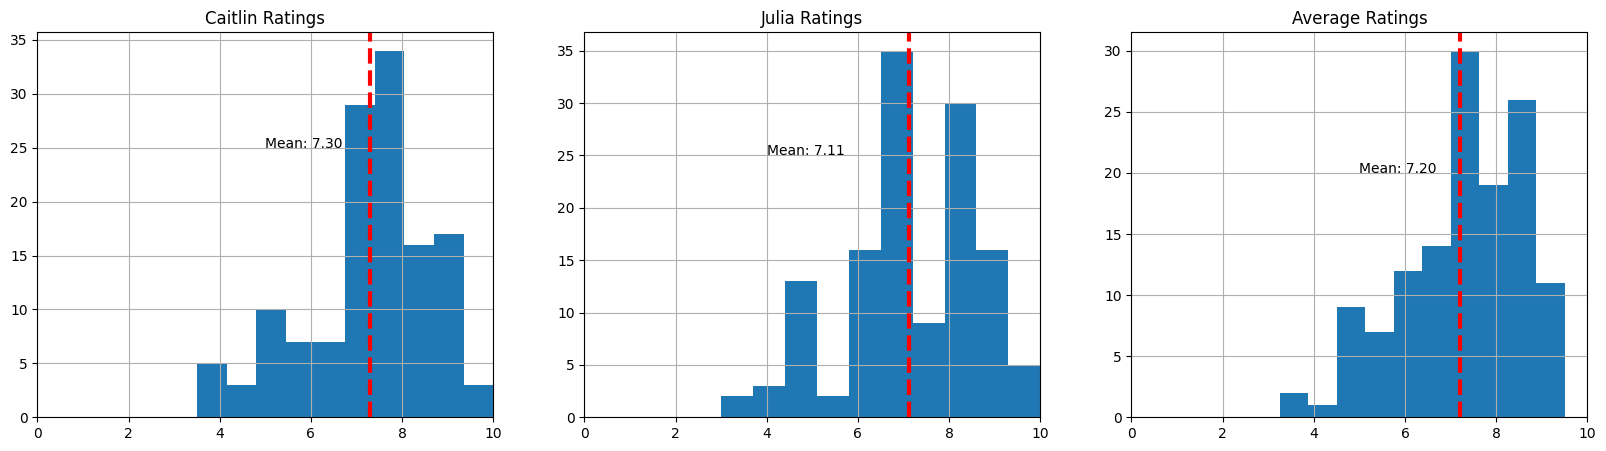

In [ ]:
watched = doc.get_worksheet(1)
watch_history = watched.get_all_values()
mov = pd.DataFrame.from_records(watch_history)
mov = mov.iloc[1:]

# any blanks coerce to NaN, replace NaN with that column's average for the purposes of graphing
mov[2] = pd.to_numeric(mov[2], errors='coerce')
mov[3] = pd.to_numeric(mov[3], errors='coerce')
mov[4] = pd.to_numeric(mov[4], errors='coerce')
mov[2] = mov[2].fillna(mov[2].mean())
mov[3] = mov[3].fillna(mov[3].mean())
mov[4] = mov[4].fillna(mov[4].mean())

cc_ratings = mov[2].astype(float)
jm_ratings = mov[3].astype(float)
avg_ratings = mov[4].astype(float)

fig, axes = plt.subplots(1, 3, figsize = (20,5))
cc_ratings.hist(ax = axes[0])
jm_ratings.hist(ax = axes[1])
avg_ratings.hist(ax = axes[2])

axes[0].axvline(x=np.nanmean(cc_ratings), color='red', linestyle='--', linewidth=3, label='Avg')
axes[1].axvline(x=np.nanmean(jm_ratings), color='red', linestyle='--', linewidth=3, label='Avg')
axes[2].axvline(x=np.nanmean(avg_ratings), color='red', linestyle='--', linewidth=3, label='Avg')
axes[0].text(5, 25, 'Mean: {:.2f}'.format(np.nanmean(cc_ratings)))
axes[1].text(4, 25, 'Mean: {:.2f}'.format(np.nanmean(jm_ratings)))
axes[2].text(5, 20, 'Mean: {:.2f}'.format(np.nanmean(avg_ratings)))

axes[0].title.set_text('Caitlin Ratings')
axes[1].title.set_text('Julia Ratings')
axes[2].title.set_text('Average Ratings')

axes[0].set_xlim([0, 10])
axes[1].set_xlim([0, 10])
axes[2].set_xlim([0, 10])

In [ ]:
import numpy as np
runtimes = pd.DataFrame(mov[8])
runtimes.head()
new = runtimes[8].str.split('h', n=1, expand=True)
hour = new[0]
min = new[1].str.split('m', n=1, expand=True)[0]
runtimes['minutes'] = hour.astype(int)*60 + min.astype(int)
tot_min = sum(runtimes['minutes'])
tot_hr = np.floor(sum(runtimes['minutes']) / 60 )
tot_day = tot_min / (60*24)
print("We've seen " + str(tot_min) + " minutes of movies together, which is " + str(tot_hr) + " hours and " + str(sum(runtimes['minutes'])%60) + " minutes or " + str(tot_day) + " days")

We've seen 14801 minutes of movies together, which is 246.0 hours and 41 minutes or 10.278472222222222 days


In [ ]:
from typing import AbstractSet
actors = mov[12]
actors = actors.str.split("/")

counts = {}
for acts in actors:
  if acts == []:
    pass
  else:
    for actor1 in acts:
      if actor1 in counts.keys():
        counts[actor1] = counts[actor1] + 1
      else:
        counts[actor1] = 1

del counts['']
dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))

{'Ryan Gosling': 5,
 'Anne Hathaway': 5,
 'Jennifer Lawrence': 4,
 'Kate Hudson': 4,
 'Florence Pugh': 4,
 'Sarah Michelle Gellar': 4,
 'Zendaya': 3,
 'James Marsden': 3,
 'Emma Stone': 3,
 'Aubrey Plaza': 3,
 'Jamie Lee Curtis': 3,
 'Andrew Garfield': 2,
 'Sandra Bullock': 2,
 'Maya Hawke': 2,
 'Bradley Cooper': 2,
 'Margot Robbie': 2,
 'Sam Claflin': 2,
 'Taylor Swift': 2,
 'Taylor Lautner': 2,
 'Natasha Lyonne': 2,
 'Daisy Edgar-Jones': 2,
 'Elisabeth Moss': 1,
 'Kristen Stewart': 1,
 'Alison Brie': 1,
 'Renee Rapp': 1,
 'Meryl Streep': 1,
 'Winona Ryder': 1,
 'Kristen Bell': 1,
 'Andy Samberg': 1,
 'Timothee Chalamet': 1}

## ML Experimentation

In [ ]:
mov_x = mov[[5,6,7,10,11,14,15]].copy() # grab meaninful features
mov_x[1] = runtimes["minutes"] # add runtime in # of mins

mov_x.columns = ['Genre1', 'Genre2', 'Year','RT','IMDb','GFCC','GenreCluster','Min']
mov_x['Year'] = pd.to_numeric(mov_x['Year'])
mov_x['RT'] = mov_x['RT'].str.rstrip('%').astype('float') / 100.0
mov_x['IMDb'] = pd.to_numeric(mov_x['IMDb'])

caitlin_y = mov[[2]]
julia_y = mov[[3]]
both_y = mov[[4]]
mov_x.shape

(131, 8)

In [ ]:
genre_cat = mov_x[['Genre1','Genre2']].stack().str.get_dummies().groupby(level=0).sum()
gfcc_cat = pd.get_dummies(mov_x[['GFCC']])
genre_cluster_cat = pd.get_dummies(mov_x[['GenreCluster']])
genre_cluster_cat.shape

(131, 6)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(mov_x[['Year','RT','IMDb','Min']])
num_x = pd.DataFrame(scaler.transform(mov_x[['Year','RT','IMDb','Min']]), columns=['Year','RT','IMDb','Min'])
num_x.head()

,Year,RT,IMDb,Min
0,0.726027,0.431579,0.653846,0.533333
1,0.630137,0.810526,0.730769,0.171429
2,0.958904,0.926316,0.903846,0.695238
3,0.767123,0.326316,0.576923,0.466667
4,0.986301,0.957895,1.000000,0.619048


In [ ]:
genre_cat.reset_index(drop=True, inplace=True)
num_x.reset_index(drop=True, inplace=True)
gfcc_cat.reset_index(drop=True, inplace=True)
genre_cluster_cat.reset_index(drop=True, inplace=True)
mov_x_all = pd.concat([genre_cat, num_x, gfcc_cat, genre_cluster_cat], axis=1)
mov_x_all = mov_x_all.dropna()
mov_x_all.shape


(131, 39)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

x_train, x_test, y_train, y_test = train_test_split(mov_x_all,both_y,test_size=.2)
rf = RandomForestRegressor()
rf.fit(x_train, np.array(y_train))
predicted = rf.predict(x_test)
mean_squared_error(y_test, predicted)

<ipython-input-152-6b4aeb377203>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, np.array(y_train))


1.3376224537037036

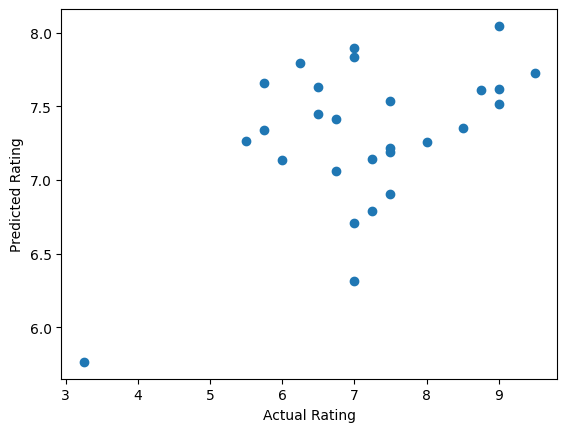

In [ ]:
plt.scatter(y_test, predicted)
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.show()